In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from datetime import date
import calendar

In [2]:
# Import & Read CSV generated from DarkSky Weather API
csv_path1= "Resources/temp_weather.csv"
weather_df = pd.read_csv(csv_path1)
# Clean weather_df
del weather_df['Unnamed: 0']


weather_df.head(1)

,Date,Temperature,Weather Condition
0,2016-02-12,20.53,Mostly Cloudy


In [3]:
# Import & Read CSV generated from Pittsburgh Crime Codes


In [4]:
#Import & Read Original Pittsburgh Crime Data CSV
csv_path3= "Resources/crime_data.csv"
master_df = pd.read_csv(csv_path3)
master_df.head(1)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551


In [5]:
# Clean master_df & Print Pittsburgh Crime DataFrame (organized_df)
# Split up ARRESTTIME column into Arrest Hour, Arrest Date, Arrest Month, Arrest Year, Arrest Unix Timestamp columns
master_df[['Date','Arrest_Time']]=master_df['ARRESTTIME'].str.split('T', expand=True,n=2)

# Drop unnecessary columns: PK, CCR, ARRESTLOCATION, OFFENSES, INCIDENTTRACT, COUNCIL_DISTRICT, PUBLIC_WORKS_DIVISION.
del master_df['PK']
del master_df['CCR']
del master_df['ARRESTTIME']
del master_df['ARRESTLOCATION']
del master_df['INCIDENTTRACT']
del master_df['COUNCIL_DISTRICT']
del master_df['PUBLIC_WORKS_DIVISION']
# Rename Columns
master_df.columns = ['Age', 'Gender', 'Race', 'Offenses Severity', 'Incident Location', 'Incident Neighborhood', 'Incident Zone', 'Incident Longitude', 'Incident Latitude', 'Date', 'Arrest_Time']
# Reorganize Columns
organized_df = master_df[['Age', 'Gender', 'Race', 'Offenses Severity', 'Date', 'Arrest_Time', 'Incident Location', 'Incident Latitude', 'Incident Longitude', 'Incident Neighborhood', 'Incident Zone']]

# Merge organized_df with weather_df
merged_df = weather_df.merge(organized_df, how="inner", on=["Date", "Date"])

# Clean & Organize merged_df
merged_df[['Arrest Year','Arrest Month','Arrest Date']]=merged_df['Date'].str.split('-', expand=True,n=2)
merged_df[['Arrest Hour','Arrest_LongTime']]=merged_df['Arrest_Time'].str.split(':', expand=True,n=1)

# Convert "Arrest Month" column from Month Numbers to Month Names
look_up = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May',
            '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}
merged_df['Arrest Month'] = merged_df['Arrest Month'].apply(lambda x: look_up[x])

# Convert "Arrest Timestamp" column into "Arrest Day" column
merged_df['Date'] = pd.to_datetime(merged_df.Date) 
merged_df['Arrest Day of Week'] = merged_df.Date.dt.weekday_name

# Create 'Arrest Time of Day' column from 'Arrest Hour' column
merged_df["Arrest Hour"] = pd.to_numeric(merged_df["Arrest Hour"])
# Create bins in which to place values based upon Time of Day
day_bins = [0, 4, 8, 12, 16, 20, 24]
# Create labels for day_bins
day_labels = ["Early Morning (12-3am)", "Morning (4-8am)", "Late Morning (9am-12pm)", "Early Afternoon (1-4pm)", "Early Evening (5-8pm)", "Evening (9-12am)"]
# Create 'Arrest Time of Day' column for storing bins
merged_df['Arrest Time of Day'] = pd.cut(merged_df['Arrest Hour'], day_bins, labels=day_labels)
merged_df["Temperature"] = pd.to_numeric(merged_df["Temperature"])
temp_bins = [0,10,20,30,40,50,60,70,80,90,100]
temp_labels = ['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s']
merged_df['Temperature Range'] = pd.cut(merged_df['Temperature'],temp_bins, labels=temp_labels)
# Delete unwanted columns
del merged_df['Date']
del merged_df['Arrest_Time']
del merged_df['Arrest_LongTime']
# Reorganize columns
full_crime_df = merged_df[['Age', 'Gender', 'Race', 'Offenses Severity', 'Arrest Time of Day', 'Arrest Hour', 'Arrest Day of Week', 'Arrest Date', 'Arrest Month', 'Arrest Year','Temperature Range', 'Temperature', 'Weather Condition', 'Incident Location', 'Incident Latitude', 'Incident Longitude', 'Incident Neighborhood', 'Incident Zone']]

# Edit 'Age' column to have no person who is less than 1 year old and no one older than 100.
indexNames = full_crime_df[(full_crime_df['Age'] >= 100) & (full_crime_df['Age'] == 0)].index
full_crime_df.drop(indexNames , inplace=True)
# Get rid of Outliers
full_crime_df.dropna(inplace=True)


# Show DataFrame
full_crime_df.head()


,Age,Gender,Race,Offenses Severity,Arrest Time of Day,Arrest Hour,Arrest Day of Week,Arrest Date,Arrest Month,Arrest Year,Temperature Range,Temperature,Weather Condition,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",Evening (9-12am),21,Friday,12,February,2016,20s,20.53,Mostly Cloudy,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6
1,31.0,M,W,13(a)(16) Possession of Controlled Substance /...,Early Afternoon (1-4pm),15,Wednesday,17,February,2016,30s,32.76,Overcast,"800 Block Concord ST Pittsburgh, PA 15212",40.457564,-79.997924,East Allegheny,1
2,31.0,F,O,9015 Failure To Appear/Arrest on Attachment Order,Late Morning (9am-12pm),9,Thursday,03,March,2016,30s,34.11,Partly Cloudy,"600 Block Liberty AV Pittsburgh, PA 15222",40.441773,-80.001620,Central Business District,2
4,36.0,M,W,13(a)(32) Paraphernalia - Use or Possession,Early Morning (12-3am),2,Friday,08,April,2016,30s,39.39,Overcast,"Boyd ST & Diamond ST Pittsburgh, PA 15219",40.438656,-79.993293,Bluff,2
5,60.0,M,W,5104 Resisting Arrest or Other Law Enforcement...,Late Morning (9am-12pm),9,Sunday,10,April,2016,30s,32.63,Overcast,"Forbes AV & Armstrong TUN Pittsburgh, PA 15219",40.437971,-79.992052,Bluff,2


In [6]:
#Created new column to hold rounded temperatures for to highlight trend(s)
full_crime_df["Rounded Temp"]=round(full_crime_df["Temperature"])
full_crime_df.head()

,Age,Gender,Race,Offenses Severity,Arrest Time of Day,Arrest Hour,Arrest Day of Week,Arrest Date,Arrest Month,Arrest Year,Temperature Range,Temperature,Weather Condition,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone,Rounded Temp
0,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",Evening (9-12am),21,Friday,12,February,2016,20s,20.53,Mostly Cloudy,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6,21.0
1,31.0,M,W,13(a)(16) Possession of Controlled Substance /...,Early Afternoon (1-4pm),15,Wednesday,17,February,2016,30s,32.76,Overcast,"800 Block Concord ST Pittsburgh, PA 15212",40.457564,-79.997924,East Allegheny,1,33.0
2,31.0,F,O,9015 Failure To Appear/Arrest on Attachment Order,Late Morning (9am-12pm),9,Thursday,03,March,2016,30s,34.11,Partly Cloudy,"600 Block Liberty AV Pittsburgh, PA 15222",40.441773,-80.001620,Central Business District,2,34.0
4,36.0,M,W,13(a)(32) Paraphernalia - Use or Possession,Early Morning (12-3am),2,Friday,08,April,2016,30s,39.39,Overcast,"Boyd ST & Diamond ST Pittsburgh, PA 15219",40.438656,-79.993293,Bluff,2,39.0
5,60.0,M,W,5104 Resisting Arrest or Other Law Enforcement...,Late Morning (9am-12pm),9,Sunday,10,April,2016,30s,32.63,Overcast,"Forbes AV & Armstrong TUN Pittsburgh, PA 15219",40.437971,-79.992052,Bluff,2,33.0


In [7]:
# Temperature (Hot vs Cold)
            # X-Axis: Temperature in Degrees F
            # Y-Axis: Amount of Crime (measured by incident number)
temp_group = full_crime_df.groupby('Rounded Temp').count()["Age"].reset_index().rename(columns={"Age":"Crimes",
                                                                                               "Rounded Temp":"Temperature (F)"})
temp_group.head()

,Temperature (F),Crimes
0,7.0,28
1,11.0,65
2,13.0,64
3,15.0,51
4,16.0,144


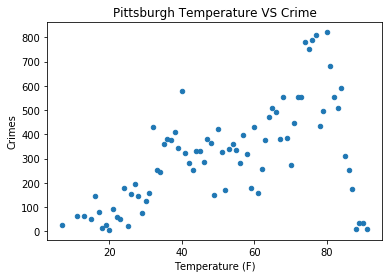

In [8]:
temp_group.plot(kind="scatter",x= "Temperature (F)" , y= "Crimes", title= "Pittsburgh Temperature VS Crime")
plt.savefig('temperature_crime.png')

In [9]:
#Breaking down 15 categories into 6 total for plotting Crime VS 
full_crime_df["Weather Type"]=full_crime_df["Weather Condition"].replace({"Mostly Cloudy":"Cloudy","Overcast":"Cloudy","Partly Cloudy":"Cloudy",
                                           "Light Rain":"Rainy","Drizzle":"Rainy","Rain":"Rainy","Clear":"Sunny",
                                           "Light Snow":"Snow","Flurries":"Snow","Humid and Mostly Cloudy":"Humid",
                                            "Humid and Overcast":"Humid","Humid and Partly Cloudy":"Humid"})
full_crime_df.head()        


,Age,Gender,Race,Offenses Severity,Arrest Time of Day,Arrest Hour,Arrest Day of Week,Arrest Date,Arrest Month,Arrest Year,Temperature Range,Temperature,Weather Condition,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone,Rounded Temp,Weather Type
0,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",Evening (9-12am),21,Friday,12,February,2016,20s,20.53,Mostly Cloudy,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6,21.0,Cloudy
1,31.0,M,W,13(a)(16) Possession of Controlled Substance /...,Early Afternoon (1-4pm),15,Wednesday,17,February,2016,30s,32.76,Overcast,"800 Block Concord ST Pittsburgh, PA 15212",40.457564,-79.997924,East Allegheny,1,33.0,Cloudy
2,31.0,F,O,9015 Failure To Appear/Arrest on Attachment Order,Late Morning (9am-12pm),9,Thursday,03,March,2016,30s,34.11,Partly Cloudy,"600 Block Liberty AV Pittsburgh, PA 15222",40.441773,-80.001620,Central Business District,2,34.0,Cloudy
4,36.0,M,W,13(a)(32) Paraphernalia - Use or Possession,Early Morning (12-3am),2,Friday,08,April,2016,30s,39.39,Overcast,"Boyd ST & Diamond ST Pittsburgh, PA 15219",40.438656,-79.993293,Bluff,2,39.0,Cloudy
5,60.0,M,W,5104 Resisting Arrest or Other Law Enforcement...,Late Morning (9am-12pm),9,Sunday,10,April,2016,30s,32.63,Overcast,"Forbes AV & Armstrong TUN Pittsburgh, PA 15219",40.437971,-79.992052,Bluff,2,33.0,Cloudy


In [10]:
temp_type = full_crime_df.groupby('Weather Type').count()["Age"].reset_index().rename(columns={"Age":"Crimes"})
temp_type


,Weather Type,Crimes
0,Cloudy,12643
1,Foggy,103
2,Humid,592
3,Rainy,2135
4,Snow,232
5,Sunny,9141


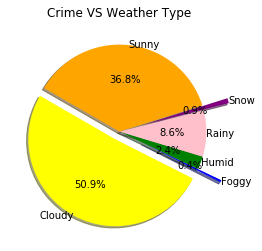

In [11]:
# Weather Condition VS Percent of Crime: 
 
labels = ["Cloudy", "Foggy", "Humid", "Rainy", "Snow", "Sunny"]
crimes = [12643,103,592,2135,232,9141]
colors = ["yellow" ,"blue" ,"green", "pink", "purple", "orange"]

explode = [.1,.3,0,0,.3,0]
     
plt.pie(crimes, labels=labels, explode=explode, colors=colors, autopct="%1.1f%%", shadow=True, 
        pctdistance=.6, labeldistance=1, startangle=150)
plt.title("Crime VS Weather Type")

plt.savefig("wtype_crime.jpg")

In [12]:
#LIAM # Crime Frequency vs Incident Location (Heatmap)
      # Crime Frequency vs Police Zone (Heatmap)


In [13]:
#LIAM # Crime Severity vs Incident Location (Heatmap)


In [14]:
#EMA # Age, Gender and Race vs Crime (Pie Charts?)
     # Crime Frequency
        # Grouped by incident location & date
    
     # Crime Type
    
     # Crime Severity (Felonies, Misdemeanors or Violations/Infractions)


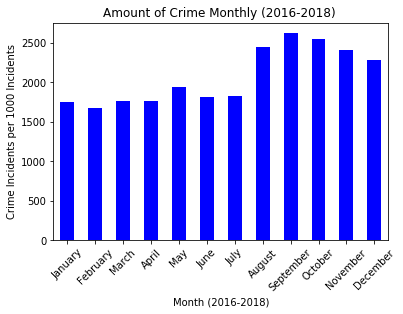

In [15]:
#PETER # Crime Frequency vs Time of Year (seasonality)
# Group data by each month
month_group = full_crime_df.groupby('Arrest Month')
# Find total amount of crime incidents in each month
monthly_crime = month_group['Arrest Date'].count()
# Organize Months to appear in correct yearly order
organized_monthly_crime = monthly_crime.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])


# Graph data & edit chart
organized_monthly_crime_chart = organized_monthly_crime.plot(kind="bar", title="Amount of Crime Monthly (2016-2018) ", 
                                        rot='45', color='blue')
organized_monthly_crime_chart.set_xlabel("Month (2016-2018)")
organized_monthly_crime_chart.set_ylabel("Crime Incidents per 1000 Incidents")
# Show graph
plt.show()

In [16]:
# Show DataFrame
# STEVIE # Crime Severity vs Time of Year (seasonality)
         #Arrest month vs len(grouped(Incident Severity))
# X-Axis: Months
# Y-Axis: Severity of Crime (measured by incident number)


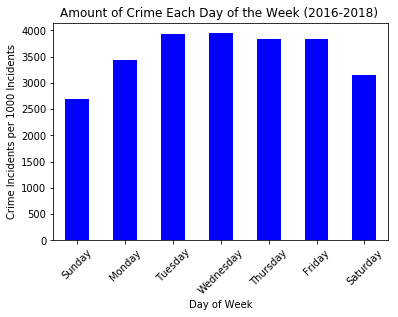

In [17]:
#PETER # Crime Frequency vs Day of Week

# Group data by each month
day_group = full_crime_df.groupby('Arrest Day of Week')
# Find total amount of crime incidents in each month
daily_crime = day_group['Arrest Date'].count()
# Organize Days of Week to be in correct order
organized_daily_crime = daily_crime.reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 
                                                 'Thursday', 'Friday', 'Saturday'])


# Graph data & edit chart
organized_daily_crime_chart = organized_daily_crime.plot(kind="bar", title="Amount of Crime Each Day of the Week (2016-2018) ", 
                                        rot='45', color='blue')
organized_daily_crime_chart.set_xlabel("Day of Week")
organized_daily_crime_chart.set_ylabel("Crime Incidents per 1000 Incidents")
# Show graph
plt.show()


In [18]:
# STEVIE Crime Severity vs Day of Week
#Arrest Day of Week vs len(grouped(Incident Severity))
# X-Axis: Day (Monday, Tuesday, Wednesday, etc.)
# Y-Axis: Severity of Crime (measured by incident type)


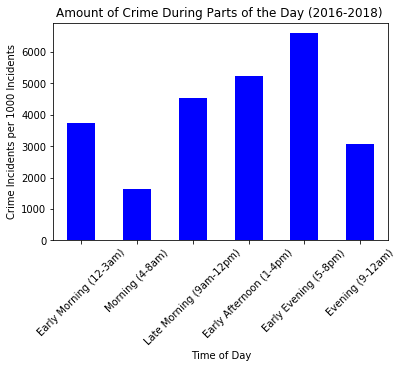

In [19]:
#PETER # Crime Frequency vs Time of Day 

# Group data by each month
day_time_group = full_crime_df.groupby('Arrest Time of Day')
# Find total amount of crime incidents in each month
day_time_crime = day_time_group['Arrest Date'].count()

# Graph data & edit chart
day_time_crime_chart = day_time_crime.plot(kind="bar", title="Amount of Crime During Parts of the Day (2016-2018) ", 
                                        rot='45', color='blue')
day_time_crime_chart.set_xlabel("Time of Day")
day_time_crime_chart.set_ylabel("Crime Incidents per 1000 Incidents")
# Show graph
plt.show()


In [20]:
# STEVIE # Crime Severity vs Time of Day 
# X-Axis: Time of Day (early morning, morning, early afternoon, noon, etc.)
# Y-Axis: Severity of Crime (measured by incident type)
full_crime_df.head()

,Age,Gender,Race,Offenses Severity,Arrest Time of Day,Arrest Hour,Arrest Day of Week,Arrest Date,Arrest Month,Arrest Year,Temperature Range,Temperature,Weather Condition,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone,Rounded Temp,Weather Type
0,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",Evening (9-12am),21,Friday,12,February,2016,20s,20.53,Mostly Cloudy,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6,21.0,Cloudy
1,31.0,M,W,13(a)(16) Possession of Controlled Substance /...,Early Afternoon (1-4pm),15,Wednesday,17,February,2016,30s,32.76,Overcast,"800 Block Concord ST Pittsburgh, PA 15212",40.457564,-79.997924,East Allegheny,1,33.0,Cloudy
2,31.0,F,O,9015 Failure To Appear/Arrest on Attachment Order,Late Morning (9am-12pm),9,Thursday,03,March,2016,30s,34.11,Partly Cloudy,"600 Block Liberty AV Pittsburgh, PA 15222",40.441773,-80.001620,Central Business District,2,34.0,Cloudy
4,36.0,M,W,13(a)(32) Paraphernalia - Use or Possession,Early Morning (12-3am),2,Friday,08,April,2016,30s,39.39,Overcast,"Boyd ST & Diamond ST Pittsburgh, PA 15219",40.438656,-79.993293,Bluff,2,39.0,Cloudy
5,60.0,M,W,5104 Resisting Arrest or Other Law Enforcement...,Late Morning (9am-12pm),9,Sunday,10,April,2016,30s,32.63,Overcast,"Forbes AV & Armstrong TUN Pittsburgh, PA 15219",40.437971,-79.992052,Bluff,2,33.0,Cloudy


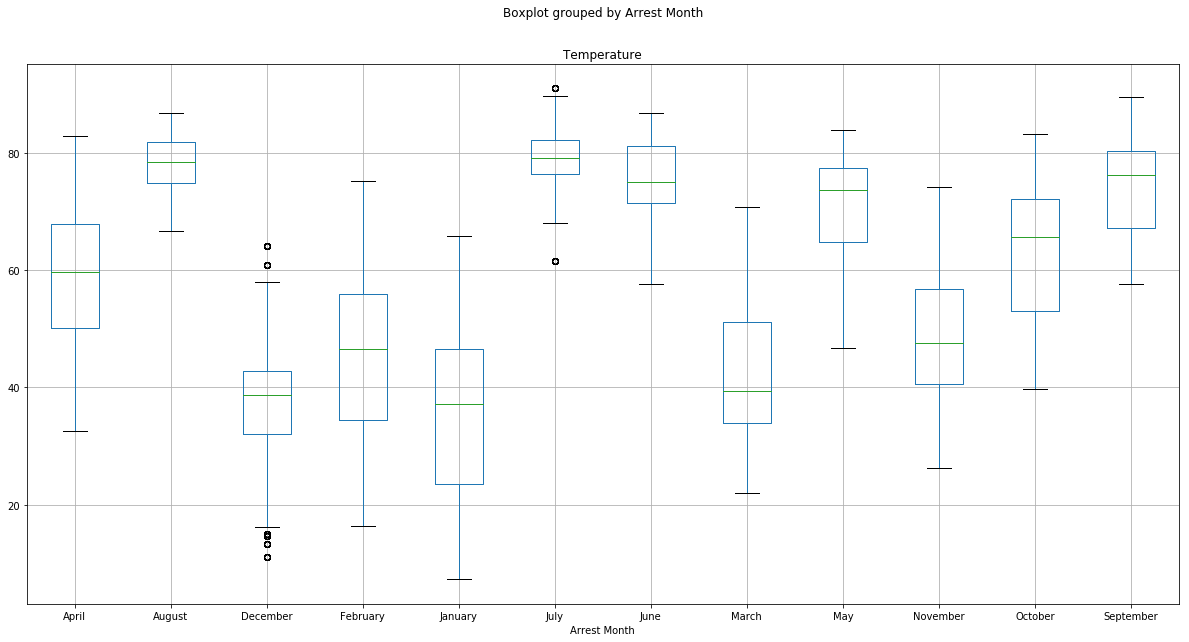

In [21]:
# TESTING
full_crime_df.boxplot("Temperature", by="Arrest Month", figsize=(20, 10))

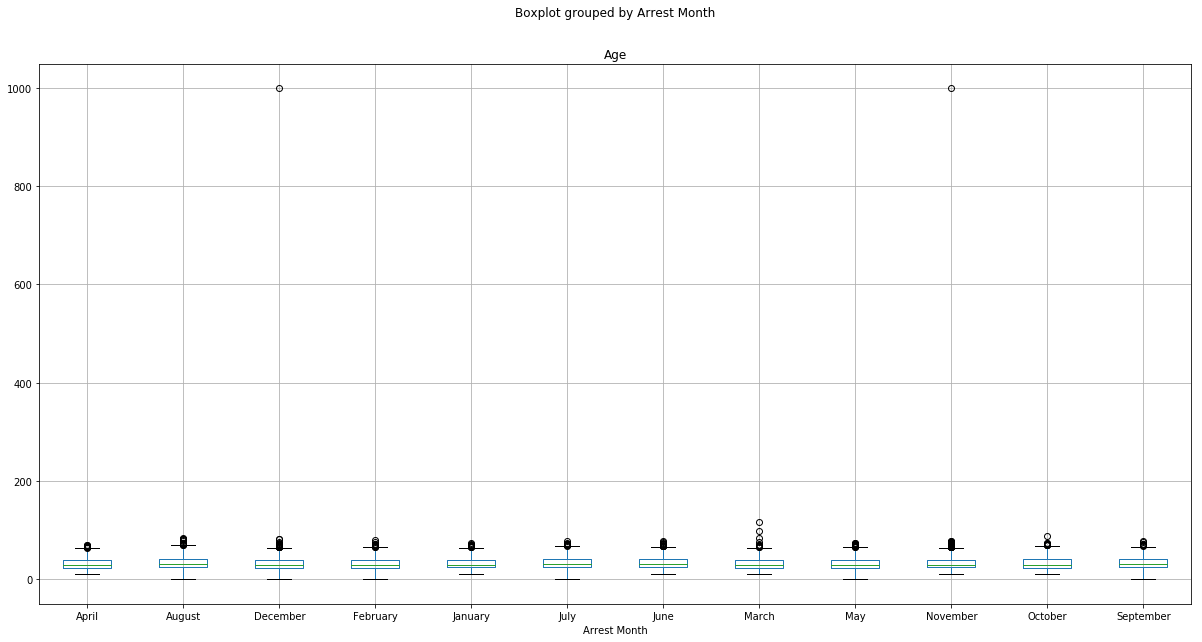

In [22]:
# TESTING
full_crime_df.boxplot("Age", by="Arrest Month", figsize=(20, 10))

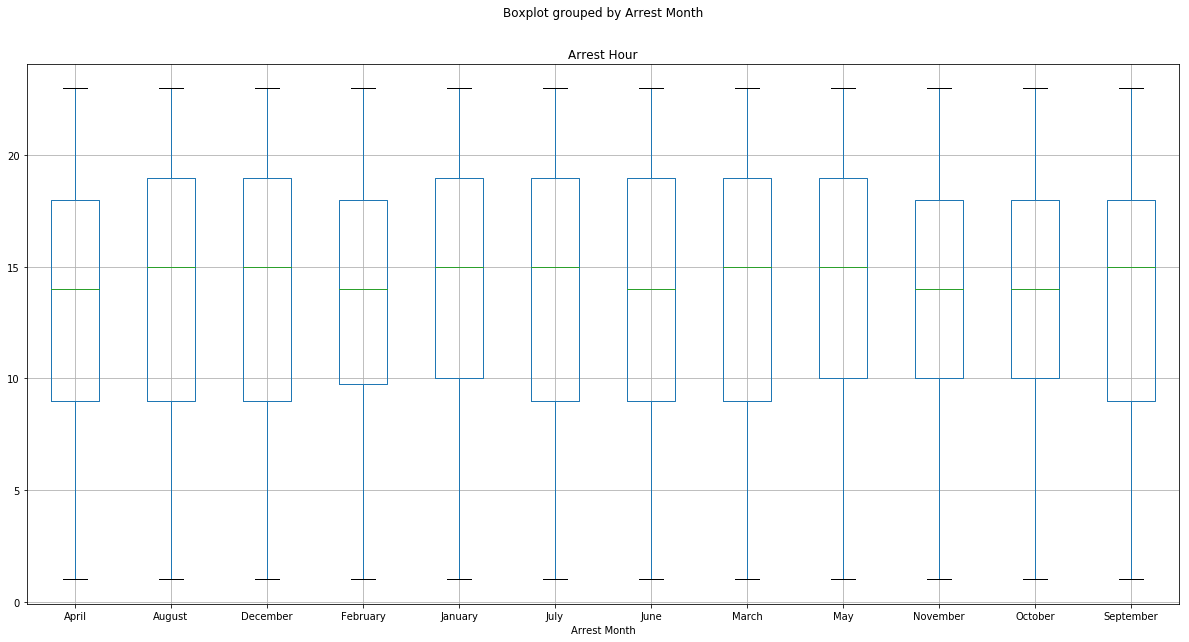

In [23]:
# TESTING
full_crime_df.boxplot("Arrest Hour", by="Arrest Month", figsize=(20, 10))